# Toy Experiments with Wasserstein-2 Generative Networks
DenseICNNs for fitting Gaussian Mixtures and a Swiss Roll.
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
torch.random.manual_seed(0xBADBEEF)

from src.icnn import DenseICNN
from src.tools import compute_l1_norm, energy_based_distance, ewma
from src import distributions

## Config

In [2]:
OUTPUT = '8g' # or 8g, 25g, 49g, 100g, swiss
L1 = 1e-10
LAMBDA = 1.
GPU_DEVICE = 0
BATCH_SIZE = 1024
LR = 1e-3

In [3]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

In [4]:
X_sampler = distributions.StandartNormalSampler(dim=2, requires_grad=True)
Y_sampler = distributions.StandardNormalScaler(requires_grad=True) # Is used to scale the input distribution

if OUTPUT == '8g':
    Y_sampler.fit(distributions.Mix8GaussiansSampler(), batch_size=100000)
elif OUTPUT == '25g':
    Y_sampler.fit(distributions.MixN2GaussiansSampler(n=5), batch_size=100000)
elif OUTPUT == '49g':
    Y_sampler.fit(distributions.MixN2GaussiansSampler(n=7), batch_size=100000)
elif OUTPUT == '100g':
    Y_sampler.fit(distributions.MixN2GaussiansSampler(n=10), batch_size=100000)
elif OUTPUT == 'swiss':
    Y_sampler.fit(distributions.SwissRollSampler(), batch_size=100000)
else:
    raise Exception('Unknown output distribution')
    
torch.cuda.empty_cache()

## Discriminators Setup

In [5]:
D = DenseICNN(
    2, rank=3, hidden_layer_sizes=[128, 128, 64],
    dropout=1e-5, strong_convexity=1e-6
).cuda()

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

# Manual weights init
for p in D.parameters():
    p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 2.
    
D_conj = DenseICNN(
    2, rank=3,
    hidden_layer_sizes=[128, 128, 64],
    dropout=1e-5, strong_convexity=1e-6
).cuda()

27520 parameters in Discriminative Network


Discriminator pretraining to satisfy $\nabla\psi_{\theta}(x)\approx x$.

In [6]:
pre_D_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.8, 0.9))

D.train(True)
loss = np.inf

for iteration in tqdm(range(10000)):
    X = (X_sampler.sample(BATCH_SIZE)).detach()
    X.requires_grad_(True)

    loss = ((D.push(X) - X) ** 2).sum(dim=1).mean() + L1 * compute_l1_norm(D)
    loss.backward()
    pre_D_opt.step()
    pre_D_opt.zero_grad()
    D.convexify()
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
    
    if loss.item() < .3 * 1e-4:
        clear_output(wait=True)
        break
print('Final Loss:', loss.item())
D_conj.load_state_dict(D.state_dict())

Final Loss: 2.99860184895806e-05


<All keys matched successfully>

## Main training

In [7]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.8, 0.99))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, betas=(0.4, 0.4))

In [8]:
loss_history = []

forward_energy = []
inverse_energy = []

In [9]:
plot_batchsize = 3000 if OUTPUT == '100g' else 1000
s = 10 if OUTPUT == '100g' else None
figsize = (16, 16) if OUTPUT == '100g' else (12, 12)
lim = 1.8 if OUTPUT == '100g' else 2.2

plot_every = 2500 if (OUTPUT in ['49g', '100g']) else 1000
max_iter = 100001 if (OUTPUT in ['49g', '100g']) else 30001

energy_every = 20
energy_batchsize = 1024

Iteration 30000


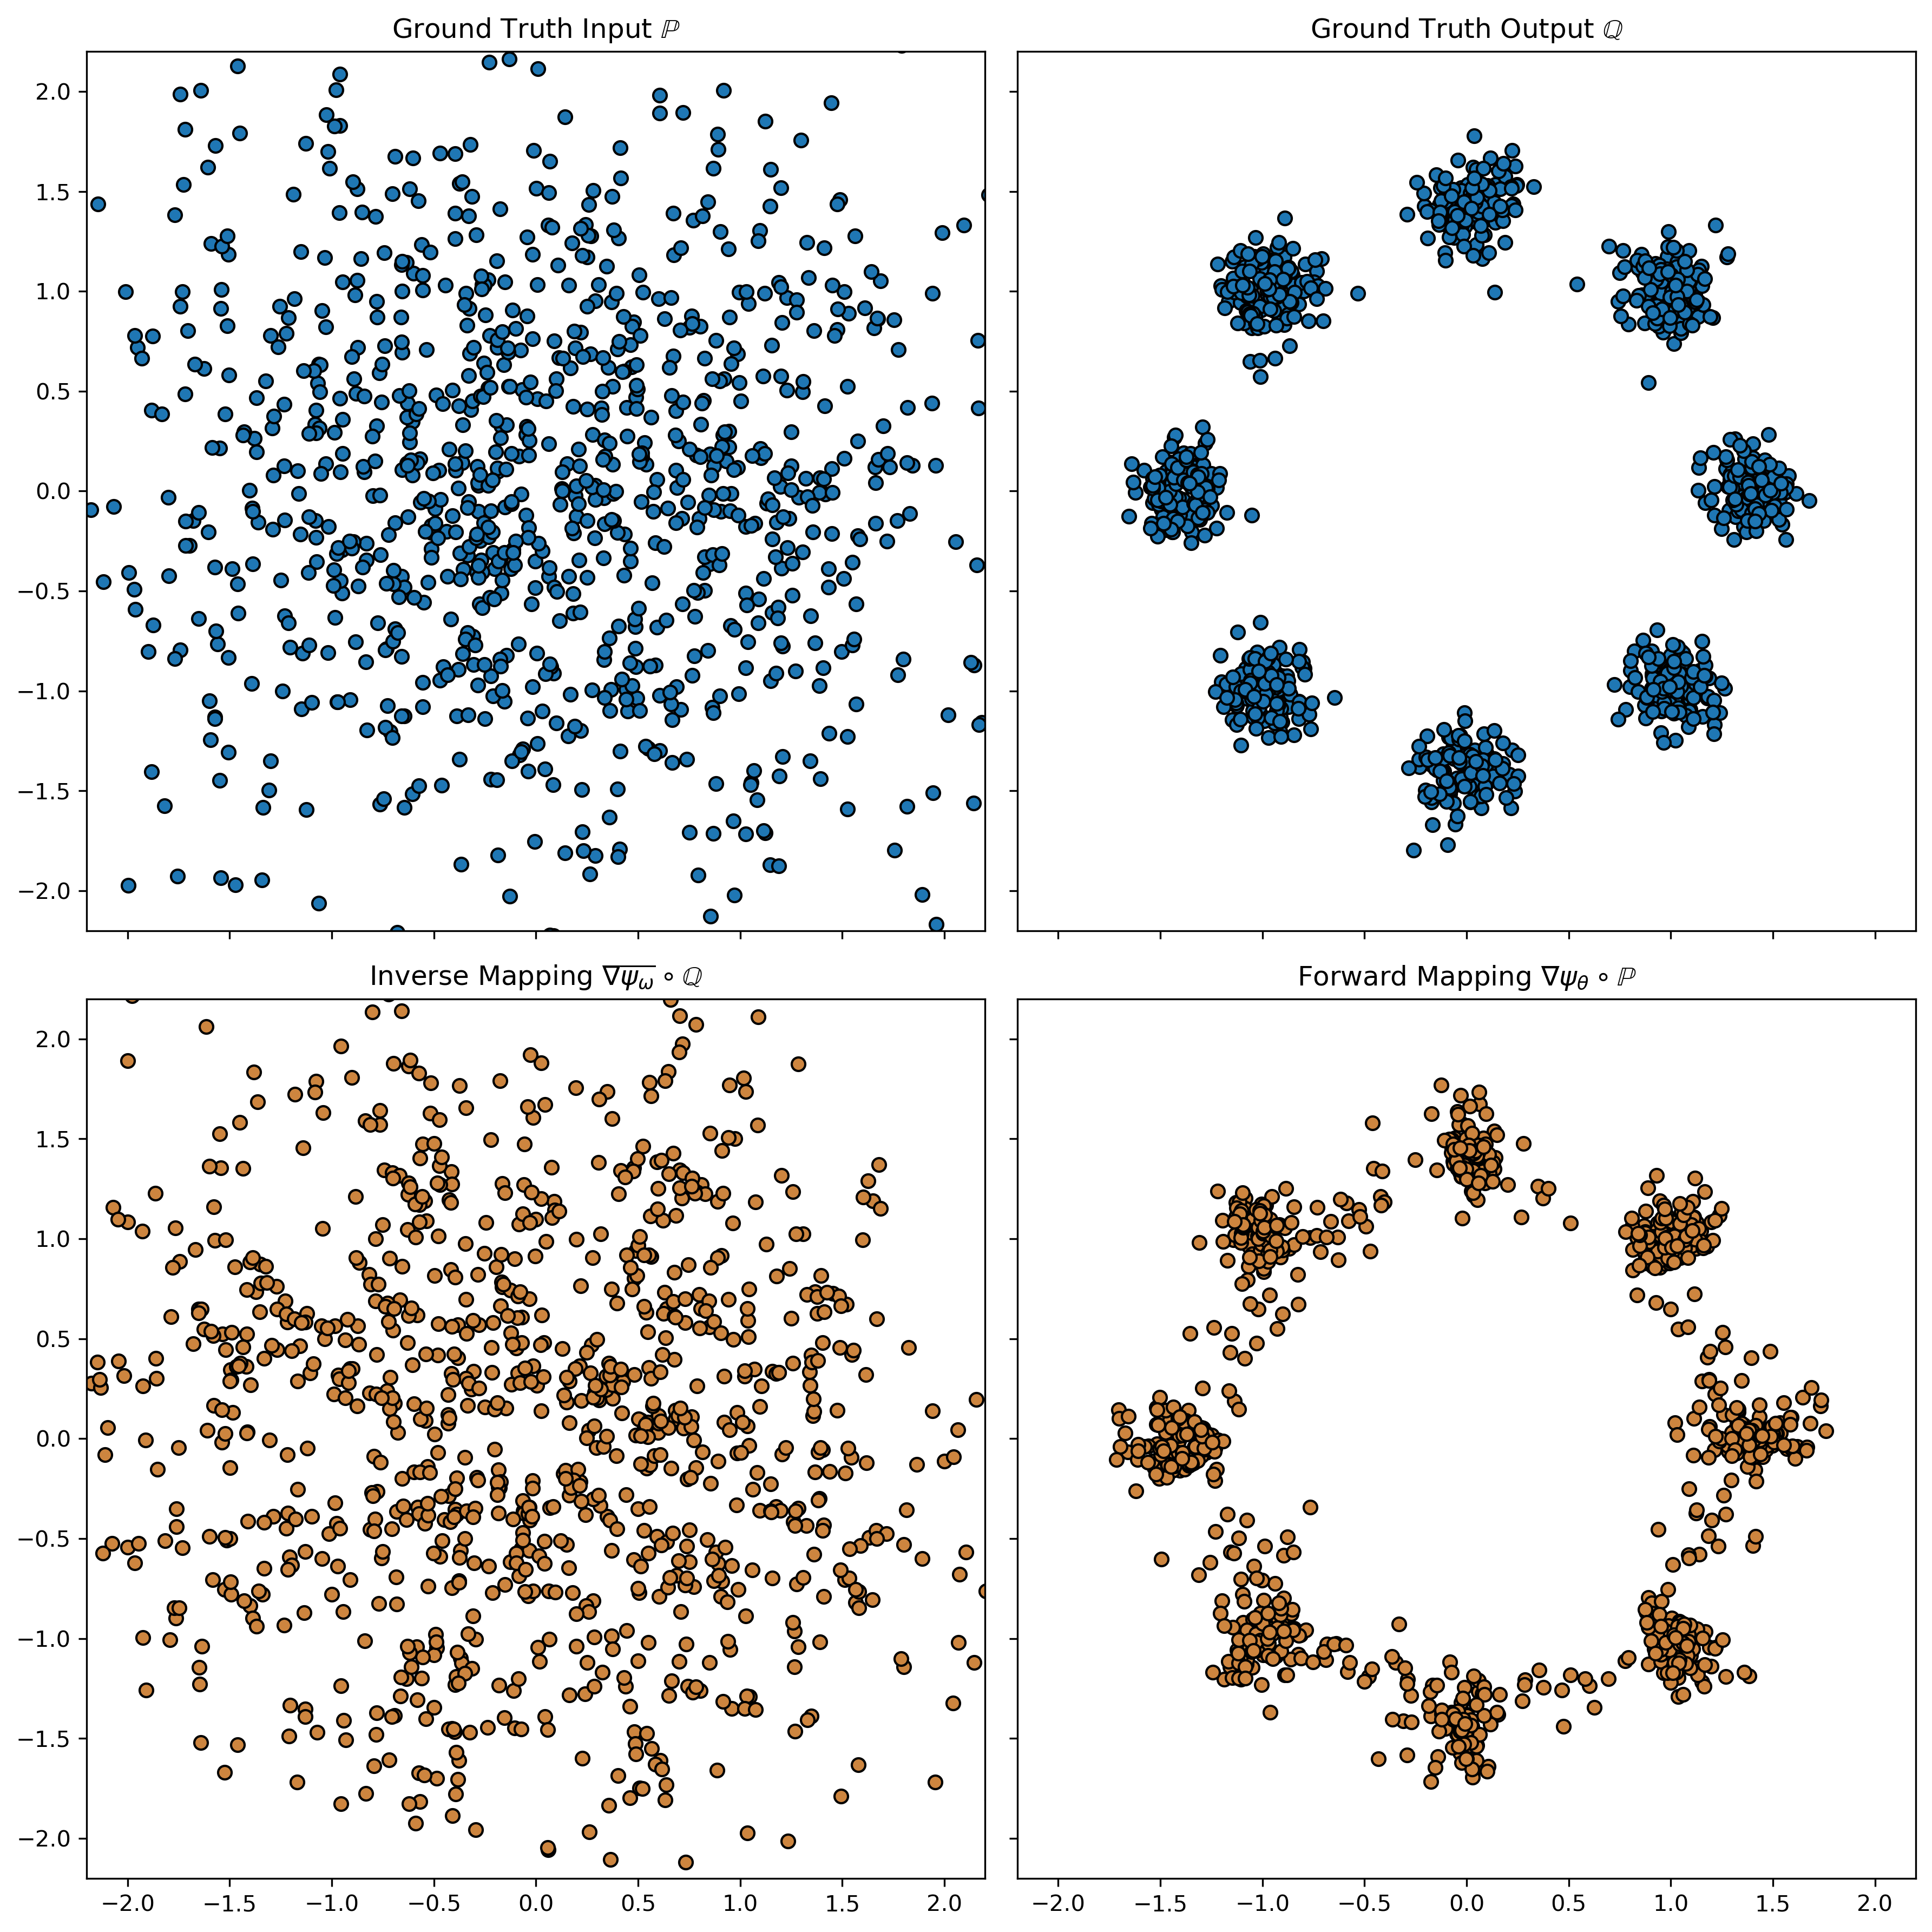

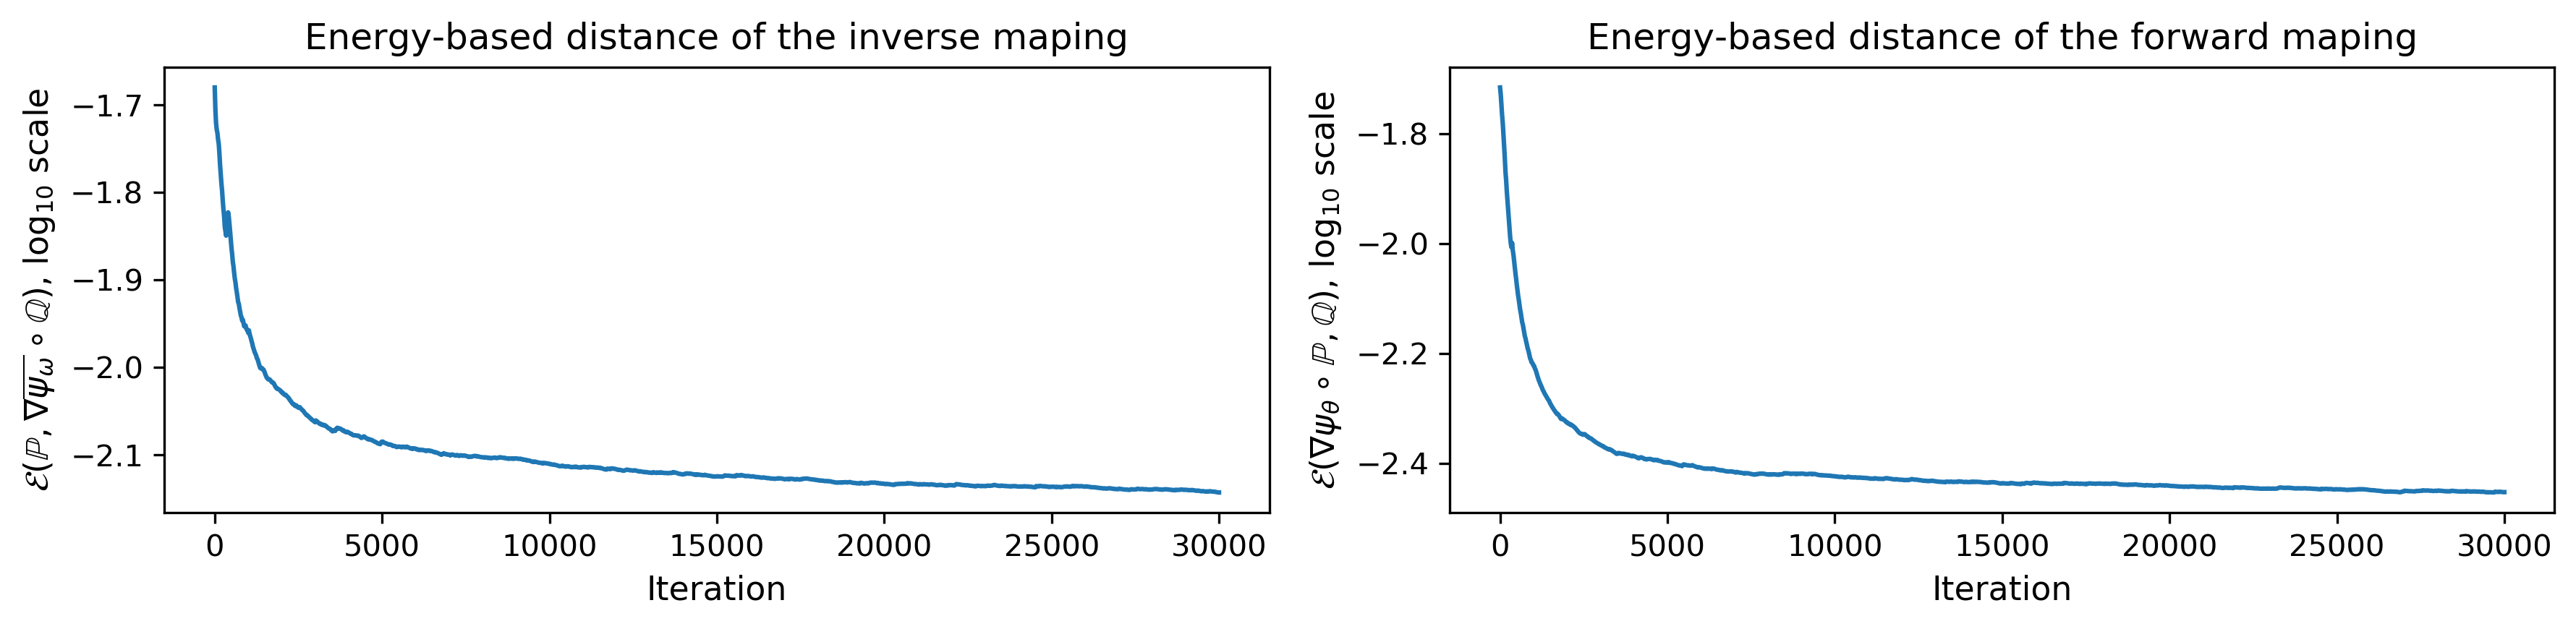

In [10]:
print('Fitting the monotone generative mapping')
for iteration in range(max_iter):
    D.train(True); D_conj.train(True)
    
    X = X_sampler.sample(BATCH_SIZE)
    Y = Y_sampler.sample(BATCH_SIZE)

    # Negative Wasserstein distance
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad()
    D_conj_opt.zero_grad()    
    W_loss = (D(X) - D(Y_inv)).mean()
    # Non-backpropagated part
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()
    
    # Weight L1 regularization
    D_reg = compute_l1_norm(D)
    D_conj_reg = compute_l1_norm(D_conj)
    W_loss += L1 * (D_reg + D_conj_reg)
    
    # Cycle Regularization
    cycle_loss = ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean()
    W_loss += LAMBDA * cycle_loss
    
    loss_history.append(W_loss.item())

    W_loss.backward()
    D_opt.step(); D_conj_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad()
    D.convexify(); D_conj.convexify()     
    
    if iteration % energy_every == 0:
        Y = Y_sampler.sample(energy_batchsize)
        X = X_sampler.sample(energy_batchsize)
        Y_inv = D_conj.push(Y).detach()
        X_push = D.push(X).detach()
        with torch.no_grad():
            forward_energy.append(energy_based_distance(X_push, Y).item())
            inverse_energy.append(energy_based_distance(X, Y_inv).item())
            
    if iteration % plot_every == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        D.train(False); D_conj.train(False)
    
        fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=300, sharex=True, sharey=True)
        axes[0, 0].set_xlim(-lim, lim); axes[0, 0].set_ylim(-lim, lim)
        axes[1, 1].set_xlim(-lim, lim); axes[1, 1].set_ylim(-lim, lim)
        Y = Y_sampler.sample(plot_batchsize)
        X = X_sampler.sample(plot_batchsize)
        Y_inv = D_conj.push(Y).cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        X_push = D.push(X).cpu().detach().numpy()
        X = X.cpu().detach().numpy()

        axes[0, 0].scatter(X[:, 0], X[:, 1], edgecolors='black', s=s)
        axes[0, 1].scatter(Y[:, 0], Y[:, 1], edgecolors='black', s=s)
        axes[1, 0].scatter(Y_inv[:, 0], Y_inv[:, 1], c='peru', edgecolors='black', s=s)
        axes[1, 1].scatter(X_push[:, 0], X_push[:, 1], c='peru', edgecolors='black', s=s)

        axes[0, 0].set_title(r'Ground Truth Input $\mathbb{P}$', fontsize=12)
        axes[0, 1].set_title(r'Ground Truth Output $\mathbb{Q}$', fontsize=12)
        axes[1, 0].set_title(
            r'Inverse Mapping $\nabla\overline{\psi_{\omega}}\circ\mathbb{Q}$',
            fontsize=12
        )
        axes[1, 1].set_title(
            r'Forward Mapping $\nabla\psi_{\theta}\circ\mathbb{P}$',
            fontsize=12
        )
        fig.tight_layout()
        plt.show()
        D.train(True); D_conj.train(True)
        
        fig, axes = plt.subplots(1, 2, figsize=(figsize[0], 3), sharex=True, dpi=300,)
        axes[1].plot(
            range(0, energy_every * len(forward_energy), energy_every),
            np.log10(np.abs(ewma(forward_energy, span=1000)))
        )
        axes[1].set_title('Energy-based distance of the forward maping', fontsize=12)
        axes[1].set_xlabel('Iteration', fontsize=11)
        axes[1].set_ylabel(r'$\mathcal{E}(\nabla\psi_{\theta}\circ \mathbb{P},\mathbb{Q})$, $\log_{10}$ scale', fontsize=11)
        
        axes[0].plot(
            range(0, energy_every * len(inverse_energy), energy_every),
            np.log10(np.abs(ewma(inverse_energy, span=1000)))
        )
        axes[0].set_title('Energy-based distance of the inverse maping', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].set_ylabel(r'$\mathcal{E}(\mathbb{P},\nabla\overline{\psi_{\omega}}\circ \mathbb{Q})$, $\log_{10}$ scale', fontsize=11)
        
        fig.tight_layout()
        plt.show()